In [8]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [9]:
delta = 0.05
beta = 20.0
N = 10
T = 1.0
Lambda = 1000.0
train_itr = 300

In [10]:
def rbf(x, beta):
    return jnp.exp(-beta*x**2)
d_rbf = jax.grad(rbf, argnums=0)

In [11]:
def rbf_func(x, theta):
    s = 0.
    for i in range(len(theta)):
        s +=theta[i] * rbf(x - delta*(i-1)+0.5, beta)
    return s

In [12]:
def d_rbf_func(x, theta):
    s = 0.
    for i in range(len(theta)):
        s += theta[i] * d_rbf(x - delta*(i-1)+0.5, beta)
    return s

In [13]:
theta = jnp.ones(50)
xs = jnp.arange(0,1,1/50)

In [14]:
df = pd.DataFrame()
df["x"] = xs
df["rbf_func"] = [float(rbf_func(x, theta)) for x in xs]
df["d_rbf_func"] = [float(d_rbf_func(x, theta)) for x in xs]

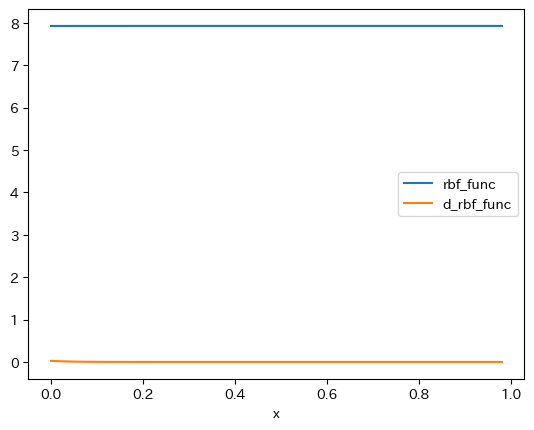

In [15]:
df.plot("x", ["rbf_func","d_rbf_func"]);

In [16]:
def Integrate(T, N, Lambda, theta):
    dt = T/N
    s = 0.
    for i in range(N):
        y = rbf_func(i*dt, theta)
        y_d = d_rbf_func(i*dt, theta)
        F = -(y**2 - y_d**2 + y*i*dt)
        s += F*dt
    s += Lambda*(rbf_func(0, theta) - 0.)**2 + Lambda*(rbf_func(1, theta) - 0.)**2
    return s

In [17]:
adam_lr = 1.
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(T, N, theta, step_num, opt_state):
    value, grads = jax.value_and_grad(Integrate, argnums=-1)(T, N, Lambda, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(T, N, theta):
    opt_state = opt_init(theta)
    for itr in trange(train_itr, leave=False):
        value, opt_state = step(T, N, Lambda, itr, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [18]:
theta_init = jnp.ones(50)
theta_trained = train(T, N, theta_init)

  0%|          | 0/300 [00:00<?, ?it/s]

loss:-0.008700656704604626   

In [20]:
ts = jnp.arange(0,1,1/50)
df2 = pd.DataFrame()
df2["t"] = ts
df2["DU-RR"] = [float(rbf_func(t, theta_trained)) for t in ts]
df2["Exact"] = [float(jnp.sin(t)/(2*jnp.sin(1.)) - t/2) for t in ts]

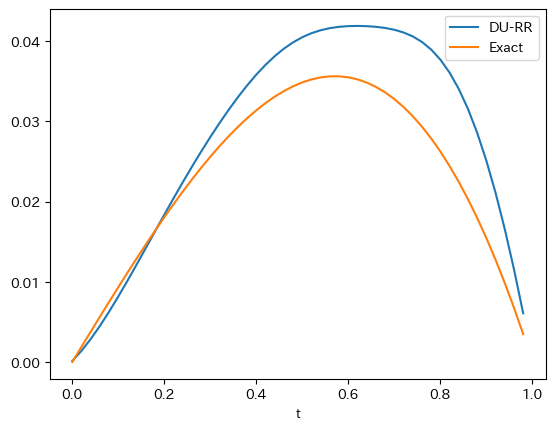

In [21]:
df2.plot("t", df2.columns[1:]);